# Importing The Libraries and The DataSets

In [1181]:
import pandas as pd 
import numpy as np
import featuretools as ft
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [1024]:
tickets = pd.read_csv('ticket_data.csv')
cities = pd.read_csv('cities.csv')
stations = pd.read_csv('stations.csv')
providers = pd.read_csv('providers.csv')

# **Partie 1 : Réponse aux Questions**

Je vais commencer par faire une transformation de type de quelque colonnes.

In [966]:
tickets['arrival_ts']= pd.to_datetime(tickets['arrival_ts'])
tickets['departure_ts']= pd.to_datetime(tickets['departure_ts'])

In [1026]:
tickets['d_station'] = tickets['d_station'].apply(lambda string : int(string) if string == string else np.nan)
tickets['o_station'] = tickets['o_station'].apply(lambda string : int(string) if string == string else np.nan)
stations['id'] = stations['id'].apply(lambda string : float(string) if string == string else np.nan)

Avant de répondre aux questions, je vais ajouter une colonne dans le tableaux **Tickets** pour la durée de chaque trajet par minutes.

In [857]:
def add(dataframe):
    arrivé = dataframe['arrival_ts'].values
    depart = dataframe['departure_ts'].values
    trajet = []
    for i in range(len(depart)) : 
        r = (arrivé[i] - depart[i])/(60*10**9)
        trajet.append(r/np.timedelta64(1, 'ns'))
    return(trajet)
tickets['trajet (min)'] = pd.DataFrame(add(tickets))
trajet = tickets['trajet (min)'].values

Je vais egalement ajouter la distance entre la ville de depart et la ville d'arrivé.

In [858]:
def distance(dataframe):
    arrivé = dataframe['o_city'].values
    depart = dataframe['d_city'].values
    distance = []
    for i in range(len(depart)) : 
        
        R = 6373.0 #Approximation du rayon de la terre
        lat1 = float(cities[cities['id'] == arrivé[i]]['latitude'])
        lat2 = float(cities[cities['id'] == depart[i]]['latitude'])
        lon1 = float(cities[cities['id'] == arrivé[i]]['longitude'])
        lon2 = float(cities[cities['id'] == depart[i]]['longitude'])
        
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        dis = R * c
        distance.append(dis)
        
    return(distance)
tickets['distance (Km)'] = pd.DataFrame(distance(tickets))
distance = tickets['distance (Km)'].values

1) Extraire les infos intéressantes 

Pour extraire les informations comme prix min, moyen et max, durée min/max/moyenne par trajet, je vais utiliser la fonction Describe et je vais obtenu le résultat.

In [859]:
tickets.describe().iloc[1:,[4,7,8]]

,price_in_cents,trajet (min),distance (Km)
mean,4382.711061,424.620793,10692.409749
std,3739.325367,594.981356,4927.641540
min,300.000000,20.000000,412.153595
25%,1900.000000,180.000000,6802.604039
50%,3350.000000,290.000000,10572.660765
75%,5250.000000,480.000000,15274.938525
max,38550.000000,29571.000000,19767.927163


On peut remarquer l'existence d'une très grande variation de prix pour les trajets, et la meme chose pour la durée du trajet.

Les informations que je vien d'extraire, sont juste des informations existantes dans le tableau **Tickets**, je peux extraire les meme informations en se basent sur la relation existante entre les 4 tableaux.

Pour ce faire, je vais utiliser l'approche de **Automated Feature Engineering**, qui est le processus de construction de caractéristiques supplémentaires à partir de données existantes qui sont souvent réparties dans plusieurs tableaux apparentés. je vais donc extraire les informations pertinentes des données et de les rassembler dans une seule table qui peut ensuite être utilisée pour former un modèle d'apprentissage machine.

Les deux premiers concepts de **Automate Feature Engineering** sont les entités et les ensembles d'entités. Une entité est simplement un tableau. Un ensemble d'entités est un ensemble de tables et les relations entre elles.

Je vais donc commencer par creer une entité :

In [860]:
tickets = pd.read_csv('ticket_data.csv')
cities = pd.read_csv('cities.csv')
stations = pd.read_csv('stations.csv')
providers = pd.read_csv('providers.csv')

In [861]:
tickets['d_station'] = tickets['d_station'].apply(lambda string : int(string) if string == string else np.nan)
tickets['o_station'] = tickets['o_station'].apply(lambda string : int(string) if string == string else np.nan)
stations['id'] = stations['id'].apply(lambda string : float(string) if string == string else np.nan)
tickets['trajet (min)'] = pd.DataFrame(trajet)
tickets['distance (Km)'] = pd.DataFrame(distance)

In [862]:
es = ft.EntitySet(id = 'tickets')

je devrais maintenant ajouter des entités. Chaque entité doit avoir un index, qui est une colonne avec tous les éléments uniques. C'est-à-dire que chaque valeur de l'index ne doit apparaître qu'une seule fois dans le tableau. L'index dans le tableaux **Tickets** est le **id**, car chaque ticket n'a qu'une seule ligne dans ce dataframe. 
C'est ce que je vais faire dans les cellules suivantes pour chaque tableaux.

In [863]:
es = es.entity_from_dataframe(entity_id = 'tickets', dataframe = tickets, 
                              index = 'id', time_index = 'departure_ts')

In [864]:
es = es.entity_from_dataframe(entity_id = 'cities', dataframe = cities, 
                              index = 'id')

In [865]:
es = es.entity_from_dataframe(entity_id = 'stations', dataframe = stations, 
                              index = 'id')

In [866]:
es = es.entity_from_dataframe(entity_id = 'providers', dataframe = providers, 
                              index = 'id')

In [867]:
print(es)

Entityset: tickets
  Entities:
    tickets [Rows: 74168, Columns: 14]
    cities [Rows: 8040, Columns: 6]
    stations [Rows: 11035, Columns: 4]
    providers [Rows: 227, Columns: 10]
  Relationships:
    No relationships


Maintenant, apres avoir creer les entités, je vais essayer de definir des relations entre les differents tableaux ( Parce que le **Id** par exemple dans le tableax **Cities** peut apparaitre dans le tableaux **Ticket** sous forme de **O_cities**), dans ce que je defini sont des jointures entre les tableaux.

In [868]:
r_cityO_previous = ft.Relationship(es['cities']['id'],es['tickets']['o_city'])
es = es.add_relationship(r_cityO_previous)

In [869]:
r_cityD_previous = ft.Relationship(es['cities']['id'], es['tickets']['d_city'])
es = es.add_relationship(r_cityD_previous)

In [870]:
r_stationO_previous = ft.Relationship(es['stations']['id'], es['tickets']['o_station'])
es = es.add_relationship(r_stationO_previous)

In [871]:
r_stationD_previous = ft.Relationship(es['stations']['id'], es['tickets']['d_station'])
es = es.add_relationship(r_stationD_previous)

In [872]:
r_company_previous = ft.Relationship(es['providers']['id'], es['tickets']['company'])
es = es.add_relationship(r_company_previous)

Je vais commencer par extraire combien de fois un element dans les 3 bases de données (Station, Cities et Providers ) existent dans la base de donnees Tickets.

In [873]:
city, feature_names = ft.dfs(entityset = es, target_entity = 'cities', 
                                 agg_primitives = ['count'])

station, feature_names = ft.dfs(entityset = es, target_entity = 'stations', 
                                 agg_primitives = ['count'])

provider, feature_names = ft.dfs(entityset = es, target_entity = 'providers', 
                                 agg_primitives = ['count'])

In [874]:
city.head()

,local_name,unique_name,latitude,longitude,population,COUNT(tickets[o_city]),COUNT(tickets[d_city])
id,,,,,,,
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0,0.0,0.0
76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0,28.0,174.0
81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN,0.0,0.0
259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0,0.0,0.0
11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN,0.0,0.0


Exemple : Dans la base donnée Ticket,  Barcelona était une ville de depart 174 fois, et ville d'arrivé 28 fois.

In [875]:
station.head()

,unique_name,latitude,longitude,COUNT(tickets[o_station]),COUNT(tickets[d_station])
id,,,,,
1.0,Aalen (Stuttgarter Straße),48.835296,10.092956,0.0,0.0
2.0,Aéroport Bordeaux-Mérignac,44.830226,-0.700883,0.0,0.0
3.0,Aéroport CDG,49.009900,2.559310,268.0,62.0
4.0,Aéroport de Berlin-Schönefeld,52.389446,13.520345,0.0,2.0
5.0,Aéroport de Dresden,51.123604,13.764737,0.0,0.0


Exemple : Dans la base donnée Ticket,  Aéroport CDG était une station de depart 268 fois, et ville d'arrivé 62 fois.

In [876]:
provider.head()

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,COUNT(tickets)
id,,,,,,,,,,
9,1,NaN,ouibus,Ouibus,True,True,True,False,bus,3560.0
10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus,9.0
11,3,NaN,infobus,Infobus,False,False,False,False,bus,0.0
12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus,5.0
13,5,NaN,flixbus,Flixbus,True,False,False,False,bus,7433.0


Exemple : Dans la base donnée Ticket,  ouibus était un moyen de transport 3560 fois et infobus0 fois.

.

Extraire de la meme façon des information **Min**.

In [877]:
city, feature_names = ft.dfs(entityset = es, target_entity = 'cities', 
                                 agg_primitives = ['min'])

station, feature_names = ft.dfs(entityset = es, target_entity = 'stations', 
                                 agg_primitives = ['min'])

provider, feature_names = ft.dfs(entityset = es, target_entity = 'providers', 
                                 agg_primitives = ['min'])

In [878]:
city.iloc[:,0:11].head()

,local_name,unique_name,latitude,longitude,population,MIN(tickets[o_city].distance (Km)),MIN(tickets[o_city].price_in_cents),MIN(tickets[o_city].trajet (min)),MIN(tickets[d_city].distance (Km)),MIN(tickets[d_city].price_in_cents),MIN(tickets[d_city].trajet (min))
id,,,,,,,,,,,
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0,NaN,NaN,NaN,NaN,NaN,NaN
76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0,945.336791,850.0,140.0,945.336791,1300.0,120.0
81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0,NaN,NaN,NaN,NaN,NaN,NaN
11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Les informations que je peux extraire du tableau au dessus est que pour l'exemple de la ville de Barcelone, le prix moyen du ticket dans le tableaux **Ticket** quand Barcelone est la ville de depart est : 140 , est le trajet min est 120 min.

Je vais faire la meme demarche pour les tableaux **Stations** et **Providers**, le resultat est le suivant :

In [879]:
station.iloc[:,0:9].head()

,unique_name,latitude,longitude,MIN(tickets[o_station].distance (Km)),MIN(tickets[o_station].price_in_cents),MIN(tickets[o_station].trajet (min)),MIN(tickets[d_station].distance (Km)),MIN(tickets[d_station].price_in_cents),MIN(tickets[d_station].trajet (min))
id,,,,,,,,,
1.0,Aalen (Stuttgarter Straße),48.835296,10.092956,NaN,NaN,NaN,NaN,NaN,NaN
2.0,Aéroport Bordeaux-Mérignac,44.830226,-0.700883,NaN,NaN,NaN,NaN,NaN,NaN
3.0,Aéroport CDG,49.009900,2.559310,668.035224,1200.0,250.0,2445.070972,1790.0,405.0
4.0,Aéroport de Berlin-Schönefeld,52.389446,13.520345,NaN,NaN,NaN,11035.551946,5090.0,1205.0
5.0,Aéroport de Dresden,51.123604,13.764737,NaN,NaN,NaN,NaN,NaN,NaN


In [880]:
provider.iloc[:,0:13].head()

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,MIN(tickets.distance (Km)),MIN(tickets.price_in_cents),MIN(tickets.trajet (min)),MIN(tickets.cities[d_city].latitude)
id,,,,,,,,,,,,,
9,1,NaN,ouibus,Ouibus,True,True,True,False,bus,768.234633,850.0,140.0,37.992379
10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus,13321.383713,2400.0,345.0,48.847702
11,3,NaN,infobus,Infobus,False,False,False,False,bus,NaN,NaN,NaN,NaN
12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus,5879.433152,1990.0,565.0,47.639674
13,5,NaN,flixbus,Flixbus,True,False,False,False,bus,668.035224,850.0,200.0,37.095300


Extraire de la meme façon des information Max.

In [881]:
city, feature_names = ft.dfs(entityset = es, target_entity = 'cities', 
                                 agg_primitives = ['max'])

station, feature_names = ft.dfs(entityset = es, target_entity = 'stations', 
                                 agg_primitives = ['max'])

provider, feature_names = ft.dfs(entityset = es, target_entity = 'providers', 
                                 agg_primitives = ['max'])

In [882]:
city.iloc[:,0:11].head()

,local_name,unique_name,latitude,longitude,population,MAX(tickets[o_city].distance (Km)),MAX(tickets[o_city].price_in_cents),MAX(tickets[o_city].trajet (min)),MAX(tickets[d_city].distance (Km)),MAX(tickets[d_city].price_in_cents),MAX(tickets[d_city].trajet (min))
id,,,,,,,,,,,
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0,NaN,NaN,NaN,NaN,NaN,NaN
76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0,15359.112743,9350.0,1475.0,14649.790331,12890.0,2535.0
81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0,NaN,NaN,NaN,NaN,NaN,NaN
11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [883]:
station.iloc[:,0:9].head()

,unique_name,latitude,longitude,MAX(tickets[o_station].distance (Km)),MAX(tickets[o_station].price_in_cents),MAX(tickets[o_station].trajet (min)),MAX(tickets[d_station].distance (Km)),MAX(tickets[d_station].price_in_cents),MAX(tickets[d_station].trajet (min))
id,,,,,,,,,
1.0,Aalen (Stuttgarter Straße),48.835296,10.092956,NaN,NaN,NaN,NaN,NaN,NaN
2.0,Aéroport Bordeaux-Mérignac,44.830226,-0.700883,NaN,NaN,NaN,NaN,NaN,NaN
3.0,Aéroport CDG,49.009900,2.559310,18672.61223,7880.0,3115.0,18672.612230,7490.0,2070.0
4.0,Aéroport de Berlin-Schönefeld,52.389446,13.520345,NaN,NaN,NaN,11035.551946,6380.0,2466.0
5.0,Aéroport de Dresden,51.123604,13.764737,NaN,NaN,NaN,NaN,NaN,NaN


In [884]:
provider.iloc[:,0:13].head()

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,MAX(tickets.distance (Km)),MAX(tickets.price_in_cents),MAX(tickets.trajet (min)),MAX(tickets.cities[d_city].latitude)
id,,,,,,,,,,,,,
9,1,NaN,ouibus,Ouibus,True,True,True,False,bus,19767.927163,14596.0,12105.0,59.899446
10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus,16447.611308,5200.0,1490.0,50.075538
11,3,NaN,infobus,Infobus,False,False,False,False,bus,NaN,NaN,NaN,NaN
12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus,12900.530735,4777.0,855.0,51.481655
13,5,NaN,flixbus,Flixbus,True,False,False,False,bus,19767.927163,22900.0,19065.0,59.899446


Extraire de la meme façon des information Mean.

In [885]:
city, feature_names = ft.dfs(entityset = es, target_entity = 'cities', 
                                 agg_primitives = ['mean'])

station, feature_names = ft.dfs(entityset = es, target_entity = 'stations', 
                                 agg_primitives = ['mean'])

provider, feature_names = ft.dfs(entityset = es, target_entity = 'providers', 
                                 agg_primitives = ['mean'])

In [886]:
city.iloc[:,0:11].head()

,local_name,unique_name,latitude,longitude,population,MEAN(tickets[o_city].distance (Km)),MEAN(tickets[o_city].price_in_cents),MEAN(tickets[o_city].trajet (min)),MEAN(tickets[d_city].distance (Km)),MEAN(tickets[d_city].price_in_cents),MEAN(tickets[d_city].trajet (min))
id,,,,,,,,,,,
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0,NaN,NaN,NaN,NaN,NaN,NaN
76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0,5918.936104,4038.214286,567.321429,8220.108146,5492.873563,964.775862
81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0,NaN,NaN,NaN,NaN,NaN,NaN
11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [887]:
station.iloc[:,0:9].head()

,unique_name,latitude,longitude,MEAN(tickets[o_station].distance (Km)),MEAN(tickets[o_station].price_in_cents),MEAN(tickets[o_station].trajet (min)),MEAN(tickets[d_station].distance (Km)),MEAN(tickets[d_station].price_in_cents),MEAN(tickets[d_station].trajet (min))
id,,,,,,,,,
1.0,Aalen (Stuttgarter Straße),48.835296,10.092956,NaN,NaN,NaN,NaN,NaN,NaN
2.0,Aéroport Bordeaux-Mérignac,44.830226,-0.700883,NaN,NaN,NaN,NaN,NaN,NaN
3.0,Aéroport CDG,49.009900,2.559310,14633.465909,3207.835821,639.085821,15890.516508,3626.467742,701.774194
4.0,Aéroport de Berlin-Schönefeld,52.389446,13.520345,NaN,NaN,NaN,11035.551946,5735.000000,1835.500000
5.0,Aéroport de Dresden,51.123604,13.764737,NaN,NaN,NaN,NaN,NaN,NaN


In [888]:
provider.iloc[:,0:13].head()

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,MEAN(tickets.distance (Km)),MEAN(tickets.price_in_cents),MEAN(tickets.trajet (min)),MEAN(tickets.cities[d_city].latitude)
id,,,,,,,,,,,,,
9,1,NaN,ouibus,Ouibus,True,True,True,False,bus,10627.288767,3333.039045,854.837640,47.317417
10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus,15730.113740,3265.555556,762.222222,49.256981
11,3,NaN,infobus,Infobus,False,False,False,False,bus,NaN,NaN,NaN,NaN
12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus,8763.584457,3868.800000,680.000000,49.550293
13,5,NaN,flixbus,Flixbus,True,False,False,False,bus,10381.315274,3759.361631,892.442486,47.518322


In [889]:
tickets.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,trajet (min),distance (Km)
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00,2017-10-13 20:10:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542,370.0,6363.227072
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00,2017-10-14 06:55:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,542,1070.0,6363.227072
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00,2017-10-14 21:24:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,1917.0,6363.227072
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00,2017-10-14 11:02:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,1295.0,6363.227072
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00,2017-10-14 19:32:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,542,1306.0,6363.227072


Partie 2 : Data Visualisation.

Dans cette partie, je vais faire quelque visualsations afin de déduire quelque informations utiles de la base de donnée.

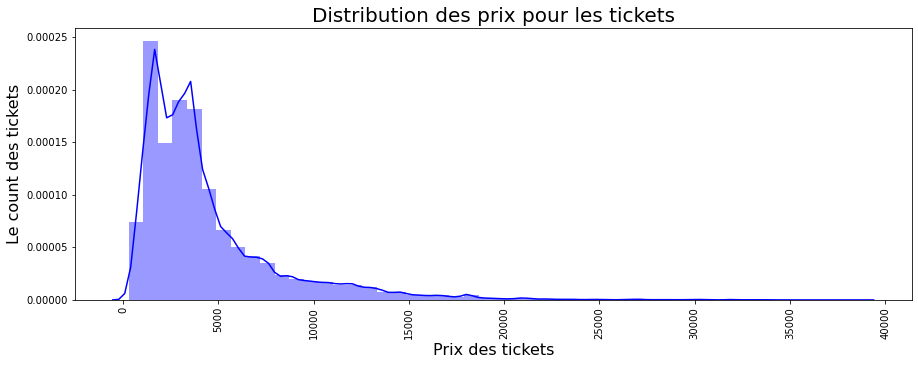

In [909]:
plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(tickets['price_in_cents'], color = 'blue')
plt.xlabel('Prix des tickets', fontsize = 16)
plt.ylabel('Le count des tickets', fontsize = 16)
plt.title('Distribution des prix pour les tickets', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

Cette distribution ne donne pas asssez d'information, pour celà, je dois appliquer le Scaling sur la base de donnnée pour nozmaliser le prix.

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(tickets['price_in_cents'], color = 'blue')
plt.xlabel('Prix des tickets', fontsize = 16)
plt.ylabel('Le count des tickets', fontsize = 16)
plt.title('Distribution des prix pour les tickets', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

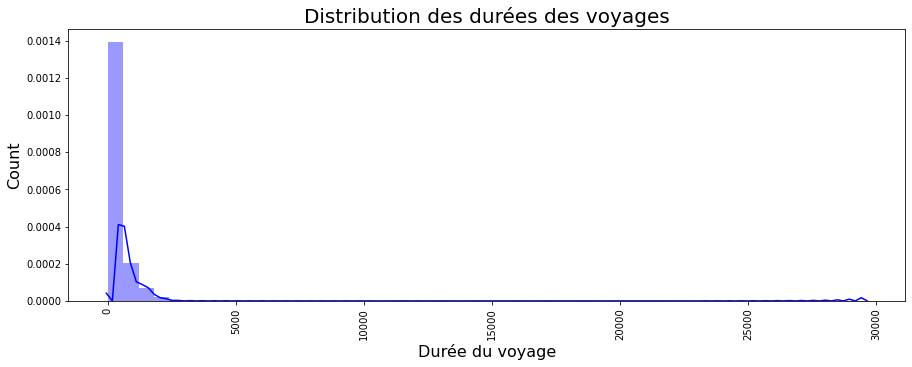

In [912]:
plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(tickets['trajet (min)'], color = 'blue')
plt.xlabel('Durée du voyage', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Distribution des durées des voyages', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

La durée n'est pas bien distribué pour les voyages, la plupart des voyages ont une durée qui ne dépasse pas 100 minutes.

# **Partie 2 : Prédiction du prix de voyage**

**1)**  Data Preprocessing and Feature Engineering

Je vais commencer par ajouter quelques informations uriles à la base de donnée **Tickets** en emplaçant l'Id des stations, villes par le nom.

In [949]:
tickets['o_city'] = tickets['o_city'].apply(lambda string : str(cities[cities['id'] == float(string)]['local_name'].values[0]) if string == string else np.nan)
tickets['d_city'] = tickets['d_city'].apply(lambda string : str(cities[cities['id'] == float(string)]['local_name'].values[0]) if string == string else np.nan)

In [950]:
tickets['d_station'] = tickets['d_station'].apply(lambda string : str(stations[stations['id'] == float(string)]['unique_name'].values[0]) if string == string else np.nan)
tickets['o_station'] = tickets['o_station'].apply(lambda string : str(stations[stations['id'] == float(string)]['unique_name'].values[0]) if string == string else np.nan)

In [951]:
tickets['company'] = tickets['company'].apply(lambda string : str(providers[providers['id'] == float(string)]['fullname'].values[0]) if string == string else np.nan)

Maintenant, je vais remplacer les colonnes **Middle Stations** et **Other Companies** pour le nombre de ces elements, par exemple pour la **Middle Stations** {12, 5}, je vais la remplacer par 2, c'est à dire le nombre de **Middle Station** traversé pendant ce voyage.

In [1032]:
tickets['middle_stations'] = tickets['middle_stations'].apply(lambda string : len(string.split(',')) if string == string else 0)
tickets['other_companies'] = tickets['other_companies'].apply(lambda string : len(string.split(',')) if string == string else 0)

Maintenant, je vais ajouter une categorie pour chaque colonne de type **Datetime**, on specifiant la periode de depart ou d'arrivvé ( Night , Morning, Evening, Afternoon).

In [1034]:
def part_day(dataframe, colonne):
    new_colonne = []
    date = dataframe[colonne].values
    for i in range(len(date)) :
        
        if 5<=float(date[i][11:13])<12 :
            new_colonne.append('Morning')
                
        if 12<=float(date[i][11:13])<17 :
            new_colonne.append('Afternoon')
            
        if 17<=float(date[i][11:13])<21 :
            new_colonne.append('Evening')
                
        if 21<=float(date[i][11:13])<24 or  0<=float(date[i][11:13])<5:
            new_colonne.append('Night')
    return(new_colonne)
    
tickets['departure_ts'] = pd.DataFrame(part_day(tickets, 'departure_ts'))
tickets['arrival_ts'] = pd.DataFrame(part_day(tickets, 'arrival_ts'))
tickets['search_ts'] = pd.DataFrame(part_day(tickets, 'search_ts'))

Maintenant, je vais ajouter une colonne catégorique, en mettant 1 si le voyage est d'un pays à an autre, 0 sinon.

In [1062]:
def type_voyage(dataframe): 
    arrivé = tickets['o_city'].values
    depart = tickets['d_city'].values
    typeV = []
    for i in range(len(depart)):
        if depart[i].split()[-1] == arrivé[i].split()[-1] :
            typeV.append(0)
        else : 
            typeV.append(1)
    return(typeV)

tickets['voy_international'] = pd.DataFrame(type_voyage(tickets))

Je vais ajouter maintenant pour chaque ville, la latitude, la longitude et la population.

In [1065]:
def add_to_city(dataframe, colonne):
    data = dataframe[colonne].values
    List_lat = []
    List_long = []
    List_pop = []
    
    for i in range(len(data)) : 
        ville = data[i]
        lat = cities[cities['local_name'] == ville]['latitude'].values[0]
        long = cities[cities['local_name'] == ville]['longitude'].values[0]
        pop = cities[cities['local_name'] == ville]['population'].values[0]
        
        List_lat.append(lat)
        List_long.append(long)
        List_pop.append(pop)
        
    return([List_lat, List_long, List_pop])

tickets['o_city_latitude'] = pd.DataFrame(add_to_city(tickets, 'o_city')[0])
tickets['o_city_lingitude'] = pd.DataFrame(add_to_city(tickets, 'o_city')[1])
tickets['o_city_population'] = pd.DataFrame(add_to_city(tickets, 'o_city')[2])

tickets['d_city_latitude'] = pd.DataFrame(add_to_city(tickets, 'd_city')[0])
tickets['d_city_longitude'] = pd.DataFrame(add_to_city(tickets, 'd_city')[1])
tickets['d_city_population'] = pd.DataFrame(add_to_city(tickets, 'd_city')[2])

maintenant, je vais ajouter à la base de donnée quelque information utiles en se basant sur la base de donnée **Providers**.

In [1083]:
def add_provider(dataframe, colonne):
    data = dataframe[colonne].values
    transport_type = []
    has_bicycle = []
    has_adjustable_seats = []
    has_plug = []
    has_wifi = []
    
    for i in range(len(data)) : 
        company = data[i]
        transport = providers[providers['fullname'] == company]['transport_type'].values[0]
        bicycle = providers[providers['fullname'] == company]['has_bicycle'].values[0]
        adjustable_seats = providers[providers['fullname'] == company]['has_adjustable_seats'].values[0]
        plug = providers[providers['fullname'] == company]['has_plug'].values[0]
        wifi = providers[providers['fullname'] == company]['has_wifi'].values[0]
        
        transport_type.append(transport)
        has_bicycle.append(bicycle)
        has_adjustable_seats.append(adjustable_seats)
        has_plug.append(plug)
        has_wifi.append(wifi)
        
    return([transport_type, has_bicycle, has_adjustable_seats, has_plug, has_wifi])

tickets['transport_type'] = pd.DataFrame(add_provider(tickets, 'company')[0])
tickets['has_bicycle'] = pd.DataFrame(add_provider(tickets, 'company')[1])
tickets['has_adjustable_seats'] = pd.DataFrame(add_provider(tickets, 'company')[2])
tickets['has_plug'] = pd.DataFrame(add_provider(tickets, 'company')[3])
tickets['has_wifi'] = pd.DataFrame(add_provider(tickets, 'company')[4])

Je vais supprimer les colonnes suivantes :

In [1095]:
dropped_columns = ['id', 'company', 'o_station', 'd_station', 'o_city', 'd_city', 'o_city_population', 'd_city_population']
tickets.drop(dropped_columns, axis=1, inplace=True)

Data Imputation : Je vais remplacer les cases vides (16 cases vides) par **False**, puisque c'est la valeur la plus denses dans la base de donnée.

In [1096]:
tickets.isnull().sum()

departure_ts             0
arrival_ts               0
price_in_cents           0
search_ts                0
middle_stations          0
other_companies          0
trajet (min)             0
distance (Km)            0
voy_international        0
o_city_latitude          0
o_city_lingitude         0
d_city_latitude          0
d_city_longitude         0
transport_type           0
has_bicycle             16
has_adjustable_seats    16
has_plug                16
has_wifi                16
dtype: int64

In [1103]:
tickets.has_bicycle .fillna('False', inplace=True)
tickets.has_adjustable_seats.fillna('False', inplace=True)
tickets.has_plug.fillna('False', inplace=True)
tickets.has_wifi.fillna('False', inplace=True)

**Splitting The DataSet into training set and Test set**

In [1208]:
prices = tickets['price_in_cents']
data = tickets.drop('price_in_cents', axis = 1)
train_data, test_data, train_targets, test_targets = train_test_split(data, prices, test_size=0.33, random_state=42)

**Transformation des données catégorique à des données numériques :**

In [1209]:
labels = ['departure_ts', 'arrival_ts', 'search_ts', 'has_bicycle', 'has_adjustable_seats', 'has_plug', 'has_wifi']
for i in labels :
    le = LabelEncoder()
    le.fit(train_data[i])
    train_data[i] = le.transform(train_data[i])
    test_data[i] = le.transform(test_data[i])

In [1210]:
lb = LabelBinarizer()
array = train_data['transport_type'].copy().values
lb.fit(array)
encoded_array = lb.transform(train_data['transport_type'].values)
if len(lb.classes_) == 2 :
         encoded_array = np.hstack((encoded_array, 1-encoded_array))
encoded_data = pd.DataFrame(encoded_array, index=train_data.index, columns=lb.classes_)
train_data[encoded_data.columns] = encoded_data
train_data.drop('transport_type', axis=1, inplace=True)

encoded_array = lb.transform(test_data['transport_type'].values)
if len(lb.classes_) == 2 :
         encoded_array = np.hstack((encoded_array, 1-encoded_array))
encoded_data = pd.DataFrame(encoded_array, index=test_data.index, columns=lb.classes_)
test_data[encoded_data.columns] = encoded_data
test_data.drop('transport_type', axis=1, inplace=True)


Mantenant, je vais applique le **Data Scaling**

In [1211]:
features = ['trajet (min)', 'distance (Km)', 'o_city_latitude', 'o_city_lingitude', 'd_city_latitude', 'd_city_longitude']
for feature in features:
    scaler = StandardScaler()
    
    array = train_data[feature].copy().values.reshape(-1, 1)
    scaler.fit(array)
    array = scaler.transform(array).squeeze()
    train_data[feature] = array
    
    array = test_data[feature].copy().values.reshape(-1, 1)
    array = scaler.transform(array).squeeze()
    test_data[feature] = array

Exploratory Data Analysis (EDA):

In [1162]:
red_tsne = TSNE(n_components=1,random_state=42).fit_transform(train_data.values)

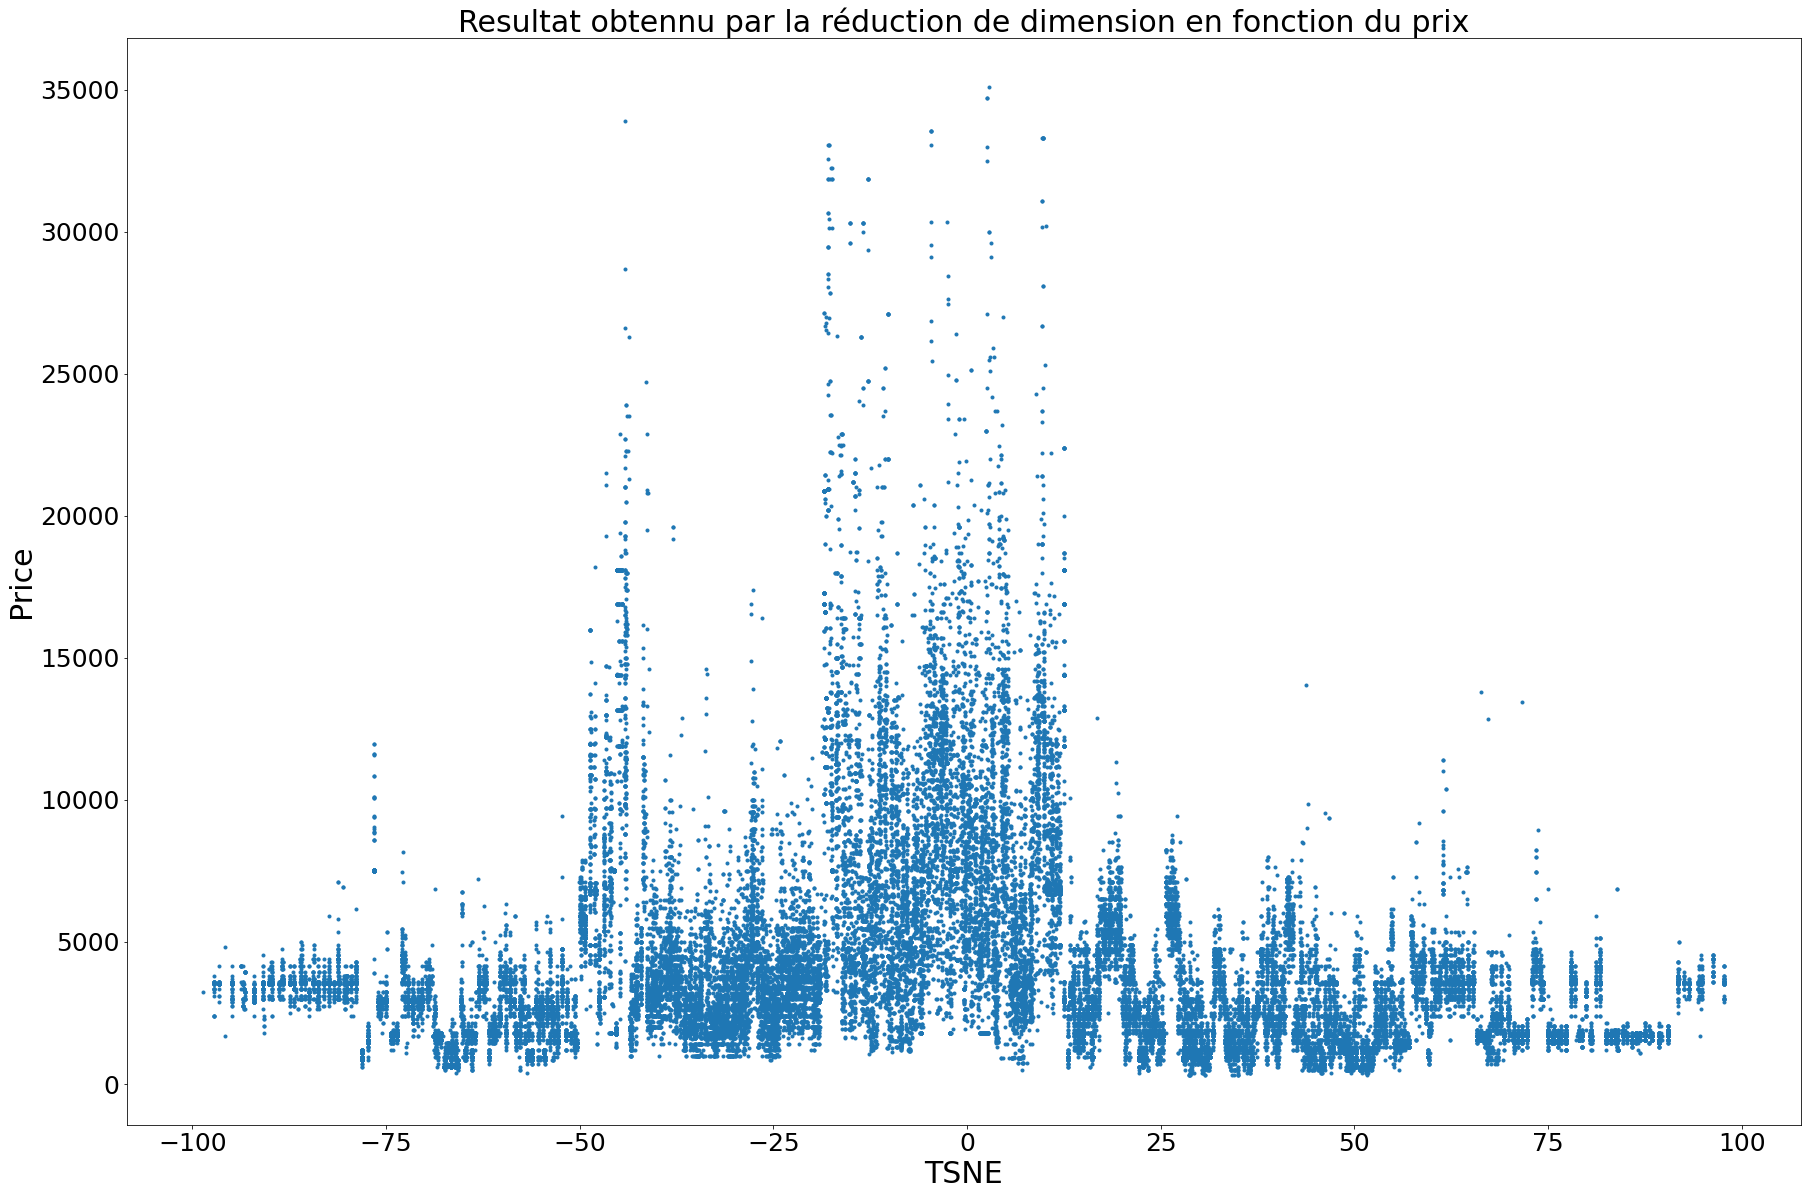

In [1170]:
plt.title('Resultat obtennu par la réduction de dimension en fonction du prix', size = 30)
plt.plot(red_tsne , train_targets, '.')
plt.xlabel('TSNE', size = 30)
plt.ylabel('Price', size = 30)
plt.xticks(size = 25)
plt.yticks(size = 25)

plt.show()

D'après la réduction de dimension précédantes, le prix de n'a pas d'une relation linéaire avec les autres colonnes, nous remarquons également l'apparition de certains OUTLIERS.


# Data Modeling : Machine Learning Application

In [1171]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

Regularization : 

In [1176]:
ridge_lr = Ridge()
params = {"alpha" : np.logspace(-3, 2, 6)}
ridge_lr_grid = GridSearchCV(ridge_lr, params, scoring='r2', cv=5)
_ = ridge_lr_grid.fit(train_data, train_targets.values)

In [1177]:
train_preds = ridge_lr_grid.predict(train_data)
test_preds = ridge_lr_grid.predict(test_data)
print("Ridge Linear Regression results :")
print(" ")
print("   -   RMSE on the train set : {:.2f}".format(mean_squared_error(train_targets, train_preds, squared=False)))
print("   -   RMSE on the test set : {:.2f}".format(mean_squared_error(test_targets, test_preds, squared=False)))
print(" ")
print("   -   R-squared on the train set : {:.2f}%".format(r2_score(train_targets, train_preds)*100))
print("   -   R-squared on the test set : {:.2f}%".format(r2_score(test_targets, test_preds)*100))

Ridge Linear Regression results :
 
   -   RMSE on the train set : 2608.28
   -   RMSE on the test set : 2589.73
 
   -   R-squared on the train set : 51.19%
   -   R-squared on the test set : 52.34%


Ridge Regression ne donne pas un bon résultat, ça est du à la non-linéarité du problème.

Je vais utiliser un algorithme de Boosting, qui est le LightGBM, et je vais faire le Hyperparameter Tunning en utilisant **L'optimisation bayésien**.

In [1212]:
from hyperopt import hp, fmin, tpe, Trials
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import cross_val_score

In [1213]:
def gb_mse_cv(params, random_state=42, cv=5, X=train_data.values, y=train_targets.values):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    
    model = LGBMRegressor(random_state=42, **params)
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    return score

In [ ]:
space = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
         'n_estimators': hp.quniform('n_estimators', 100, 2000, 100),
         'max_depth' : hp.quniform('max_depth', 2, 20, 1),
         'num_leaves': hp.quniform('num_leaves', 31, 255, 4),
         'min_child_weight': hp.uniform('min_child_weight', 0.1, 10),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.),
         'subsample': hp.uniform('subsample', 0.5, 1.),
         'reg_alpha': hp.uniform('reg_alpha', 0.001, 1),
         'reg_lambda': hp.uniform('reg_lambda', 0.001, 20)}

trials = Trials()
best = fmin(fn=gb_mse_cv, space=space, algo=tpe.suggest, max_evals=300, trials=trials, rstate=np.random.RandomState(42))
best['n_estimators'] = int(best['n_estimators'])
best['num_leaves'] = int(best['num_leaves'])
best['max_depth'] = int(best['max_depth'])
model = LGBMRegressor(random_state=42, **best)
_ = model.fit(train_data,train_targets)

In [ ]:
train_preds = model.predict(train_data)
test_preds = model.predict(test_data)
print("Light Gradient Boosting logarithmic results :")
print(" ")
print("   -   RMSE on the train set : {:.2f}".format(mean_squared_error(train_targets, train_preds, squared=False)))
print("   -   RMSE on the test set : {:.2f}".format(mean_squared_error(test_targets, test_preds, squared=False)))
print(" ")
print("   -   R-squared on the train set : {:.2f}%".format(r2_score(train_targets, train_preds)*100))
print("   -   R-squared on the test set : {:.2f}%".format(r2_score(test_targets, test_preds)*100))

**2)  La signification du RMSE.**

In [1216]:
train_targets.describe()

count    49692.000000
mean      4379.829228
std       3733.522277
min        300.000000
25%       1900.000000
50%       3350.000000
75%       5250.000000
max      35100.000000
Name: price_in_cents, dtype: float64

Nous pouvons voir que notre erreur moyenne (RMSE) dans le LGBoost initial est d'environ 2000. Étant donné qu'après avoir nettoyé la colonne des prix et les autres colonnes, 50% des voyages coûtent que jusqu'à 3350 et 75% jusqu'à 5250 - même l'écart-type amélioré de 17€3733 est une inexactitude assez massive qui n'aide pas beaucoup à recommander un prix.

Il s'avère que le prix ne dépend pas seulement des données utilisés au début. Il va sans dire que

la qualité de la présentation ,
la disponibilité,
la communication 
le statut du moyen du transport
Il pourrait également avoir une influence considérable. Mais le but de cette analyse était de recommander un prix à une "recrue" sans aucun examen ni statut. Dans cette optique, nous pourrions dire que nous ne pouvons pas recommander un prix exact, mais plutôt des environs du prix.